In [1]:
import torch
import torch.nn as nn
import lightning as L
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics import Accuracy, ConfusionMatrix
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning import Trainer
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import timm
from data.MRIDataModule_Alexandre import MRIDataModule

from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
class MyModel(L.LightningModule):
    def __init__(self,
                 lr: float = 0.001,
                 weight_decay: float = 1e-4,
                 num_class: int = 3,
                 class_counts= [135, 205, 580],  
                 *args,
                 **kwargs):
        super().__init__()
        self.save_hyperparameters()
        
        total_count = sum(class_counts)
        class_weights = [total_count / count for count in class_counts]
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
 
        
        self.model = timm.create_model(
            'resnet51q.ra2_in1k',
            pretrained=True,
            pretrained_cfg_overlay=dict(file='../Timm/resnet51q.safetensors'),
            in_chans=1,
            num_classes=0)
 
        in_features = self.model.num_features       
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(in_features, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, self.hparams.num_class)
        # Utilisation des poids dans la fonction de perte
        self.loss_train = nn.CrossEntropyLoss(weight=class_weights)
        self.loss_val = nn.CrossEntropyLoss(weight=class_weights)
        self.loss_test = nn.CrossEntropyLoss(weight=class_weights)
 
        
        self.train_acc = Accuracy(task="multiclass", num_classes=self.hparams.num_class)
        self.valid_acc = Accuracy(task="multiclass", num_classes=self.hparams.num_class)
        self.test_acc = Accuracy(task="multiclass", num_classes=self.hparams.num_class)
 
        self.train_labels = []
        self.train_preds = []

    def forward(self, x):
        x = self.model.forward_features(x)  
        x = self.pooling(x)  
        x = torch.flatten(x, 1)  
        x = F.relu(self.batch_norm1(self.fc1(x))) 
        x = self.dropout1(x)
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout2(x)
        logits = self.fc3(x)
        return logits

    def get_input(self, batch):
        return batch['preMRI'], batch['class']

    def training_step(self, batch, batch_idx):
        x, y = self.get_input(batch)
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x)
        loss = self.loss_train(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = self.train_acc(preds, y)
        self.log('train/loss', loss, prog_bar=True, on_step=True, on_epoch=True, sync_dist=True)
        self.log('train/acc', acc, prog_bar=True, on_step=True, on_epoch=True, sync_dist=True)
        self.train_labels.append(y.cpu())
        self.train_preds.append(preds.cpu())
        return loss

    def on_epoch_end(self):
        all_labels = torch.cat(self.train_labels)
        all_preds = torch.cat(self.train_preds)
        cm = confusion_matrix(all_labels, all_preds, labels=list(range(self.hparams.num_class)))
        self.log_confusion_matrix(cm)
        self.train_labels = []
        self.train_preds = []

    def validation_step(self, batch, batch_idx):
        x, y = self.get_input(batch)
        x, y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            preds = self(x)
            loss = self.loss_val(preds, y)
            preds = torch.argmax(preds, dim=1)
            acc = self.valid_acc(preds, y)
        
        self.log('val/loss', loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log('val/acc', acc, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        x, y = self.get_input(batch)
        x, y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            preds = self(x)
            loss = self.loss_test(preds, y)
            preds = torch.argmax(preds, dim=1)
            acc = self.test_acc(preds, y)
        
        self.log('test/loss', loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log('test/acc', acc, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return {'test_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val/loss',
            }
        }

In [3]:
class MetricsLogger(L.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
 
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_losses.append(trainer.callback_metrics.get('train/loss', torch.tensor(float('nan'))).item())
        self.train_accuracies.append(trainer.callback_metrics.get('train/acc', torch.tensor(float('nan'))).item())
 
    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_losses.append(trainer.callback_metrics.get('val/loss', torch.tensor(float('nan'))).item())
        self.val_accuracies.append(trainer.callback_metrics.get('val/acc', torch.tensor(float('nan'))).item())
 
    def on_train_end(self, trainer, pl_module):
        epochs = range(1, min(len(self.train_losses), len(self.val_losses)) + 1) 
        plt.figure(figsize=(10, 5))
 
        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses[:len(epochs)], label='Train Loss')
        plt.plot(epochs, self.val_losses[:len(epochs)], label='Val Loss')
        plt.title('Train vs Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
 
        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies[:len(epochs)], label='Train Accuracy')
        plt.plot(epochs, self.val_accuracies[:len(epochs)], label='Val Accuracy')
        plt.title('Train vs Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
 
        plt.tight_layout()
        plt.show()

In [6]:
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss",
    dirpath="checkpoints11/",
    filename="best_model",
    save_top_k=1,
    mode="min",
)
early_stopping_callbak = EarlyStopping(
    monitor="val/loss",
    mode="min",
    patience=100,
    verbose=True
)
metrics_logger = MetricsLogger()

trainer = L.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callbak, metrics_logger],
    max_epochs=500,
    accelerator='gpu',
    devices='auto'
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
model = MyModel()

db_path = '../data'
task = 'classification'
manifest = f'MRI_dataset_{task}_3classes.csv'

data = MRIDataModule(
    dataset_path=db_path,
    manifest_filename=manifest,
    batch_size=12,
    task=task,
    crop_size=None,
    train_val_test_shuffle=(True, False, False),
    train_val_test_split=(0.6, 0.2, 0.2),
    weighted_sample=False,
    seed=23,
    verbose=True,
    normalization='max',
    num_workers=None)

C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\M105411\Documents\IA_Med_Im\IA_Med_Im_PyTorch\checkpoints11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
C:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

   | Name        | Type               | Params | Mode 
------------------------------------------------------------
0  | model       | ByobNet            | 33.6 M | train
1  | pooling     | AdaptiveAvgPool2d  | 0      | train
2  | fc1         | Linear             | 1.0 M  | train
3  | batch_norm1 | BatchNorm1d        | 1.0 K  | train
4  | dropout1    | Dropout            | 0      | train
5  | fc2         | Linear             | 65.7 K | train
6  |

trainset size: 575
validation size: 165
testset size: 180


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 12. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pyto

Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 11. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val/loss improved. New best score: 1.074


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.068 >= min_delta = 0.0. New best score: 1.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.071 >= min_delta = 0.0. New best score: 0.934


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.016 >= min_delta = 0.0. New best score: 0.919


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/loss did not improve in the last 100 records. Best score: 0.919. Signaling Trainer to stop.


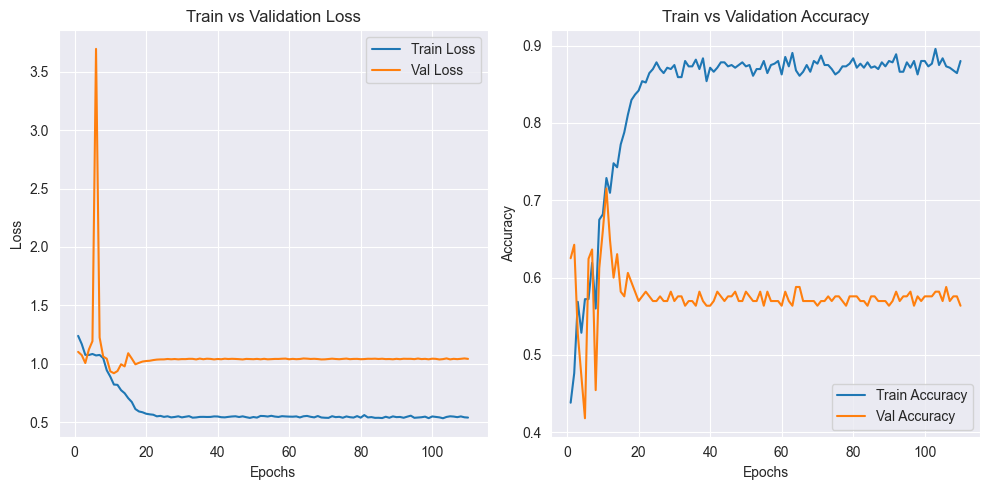

In [8]:
trainer.fit(model, data)

In [9]:
best_model_path = checkpoint_callback.best_model_path
print(best_model_path)
best_model = MyModel.load_from_checkpoint(best_model_path)
best_model.eval()

C:\Users\M105411\Documents\IA_Med_Im\IA_Med_Im_PyTorch\checkpoints11\best_model-v12.ckpt


MyModel(
  (model): ByobNet(
    (stem): Stem(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (conv4): ConvNormAct(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
    )
    (stages): Sequential(
      (0): Sequential(
        (0): BottleneckBlock(
          (shortcut): ConvNormAct(
            (conv): Co

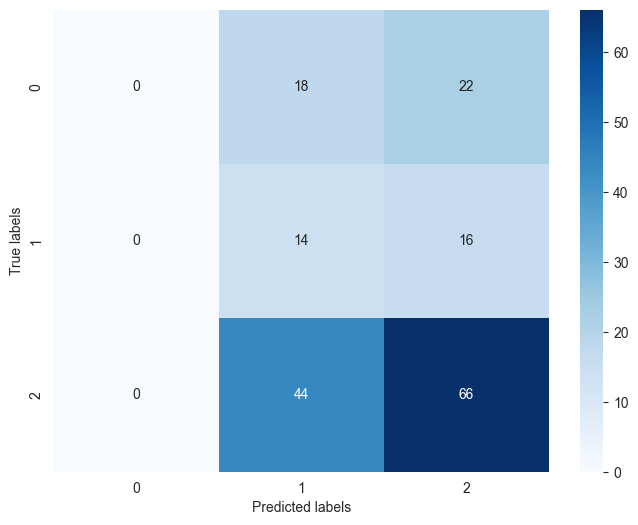

In [11]:
def get_input(batch):
        return batch['preMRI'], batch['class']

val_data = data.test_dataloader()  
 
val_labels = []
val_preds  = []
val_probs  = []  

with torch.no_grad():
    for batch in val_data:
        x, y = get_input(batch)
        x, y = x.to(best_model.device), y.to(best_model.device)
        preds = best_model(x)
        val_labels.append(y.cpu())
        val_preds.append(torch.argmax(preds, dim=1).cpu())

val_labels = torch.cat(val_labels)
val_preds  = torch.cat(val_preds)
 
cm = confusion_matrix(val_labels, val_preds, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2])

ax.set_ylabel('True labels')
ax.set_xlabel('Predicted labels')
plt.show()